# `Attention`机制

- 在机器翻译中，点积注意力的用法如下所示
![](../images/scaled-dot-product-attention.png)

> - 图中`Decoder`的隐藏状态向量`query` $q_t$ 与`Encoder`的隐藏状态向量序列`key` $K=[k_1, k_2, k_3, k_4]$ 每个向量做点积，每个 `key`向量对应一个分数
- 然后`sofmax`转换为权重分布，权重值越大可以认为越“关注”该处向量的信息
- 每个位置的 $v$ 与该处的权重相乘，然后求和得到 $q_t$ 对 $K$ 做注意力的输出向量

## `attenntion from scratch`

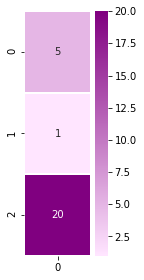

In [2]:
# 以 decoder 的 hidden state 作为 query
dec_hidden_state = [5, 1, 20]


# 可视化 query 向量
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(1.5, 4.5))
sns.heatmap(np.transpose(np.matrix(dec_hidden_state)),
            annot=True,
            cmap=sns.light_palette("purple", as_cmap=True),
            linewidths=1);

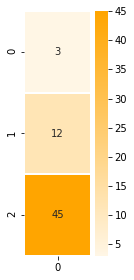

In [3]:
# encoder 的 hidden state 作为 key
annotation = [3, 12, 45]

# 可视化 key 向量
plt.figure(figsize=(1.5, 4.5))
sns.heatmap(np.transpose(np.matrix(annotation)),
            annot=True,
            cmap=sns.light_palette("orange", as_cmap=True),
            linewidths=1);

In [4]:
# 计算 attention score
def single_dot_attention_score(dec_hidden_state, enc_hidden_state):
    return np.dot(dec_hidden_state, enc_hidden_state)


single_dot_attention_score(dec_hidden_state, enc_hidden_state=annotation)

927

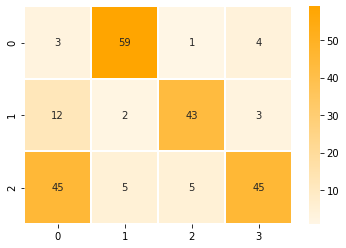

In [5]:
# encoder 的 hidden state 矩阵，即 query 与多个 key 进行注意力运算
annotations = np.transpose([[3, 12, 45], [59, 2, 5], [1, 43, 5], [4, 3, 45.3]])

# key 矩阵
ax = sns.heatmap(annotations,
                 annot=True,
                 cmap=sns.light_palette("orange", as_cmap=True),
                 linewidths=1);

In [14]:
# 计算 query 与多个 key 的 attention score
def dot_attention_score(dec_hidden_state, annotations):
    return np.matmul(np.transpose(dec_hidden_state), annotations)


attention_scores = dot_attention_score(dec_hidden_state, annotations)
attention_scores

array([927., 397., 148., 929.])

In [16]:
# 计算 attention weights
def softmax(x):
    x = np.array(x, dtype=np.float128)
    e_x = np.exp(x)
    return e_x / e_x.sum(axis=0)


attention_weights = softmax(attention_scores)
attention_weights

# 第一个和最后一个的注意力权重分别为 0.119 和 0.880

array([1.19202922e-001, 7.94715151e-232, 5.76614420e-340, 8.80797078e-001],
      dtype=float128)

In [17]:
# 从 decoder 的隐藏层序列中每个抽取多大比例
def apply_attention_scores(attention_weights, annotations):
    return attention_weights * annotations


applied_attention = apply_attention_scores(attention_weights, annotations)
applied_attention

array([[3.57608766e-001, 4.68881939e-230, 5.76614420e-340,
        3.52318831e+000],
       [1.43043506e+000, 1.58943030e-231, 2.47944200e-338,
        2.64239123e+000],
       [5.36413149e+000, 3.97357575e-231, 2.88307210e-339,
        3.99001076e+001]], dtype=float128)

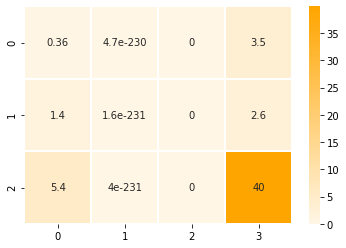

In [18]:
ax = sns.heatmap(applied_attention,
                 annot=True,
                 cmap=sns.light_palette("orange", as_cmap=True),
                 linewidths=1)

In [19]:
# 计算 attention 的输出
def calculate_attention_vector(applied_attention):
    return np.sum(applied_attention, axis=1)

attention_vector = calculate_attention_vector(applied_attention)
attention_vector

array([ 3.88079708,  4.0728263 , 45.26423912], dtype=float128)

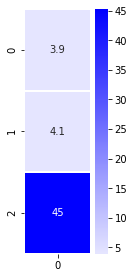

In [20]:
# 可视化 attention 输出
plt.figure(figsize=(1.5, 4.5))
sns.heatmap(np.transpose(np.matrix(attention_vector)),
            annot=True,
            cmap=sns.light_palette("Blue", as_cmap=True),
            linewidths=1)

## `PyTorch`实现

In [11]:
import torch, math, torch.nn.functional as F


def attention(query, key, value, mask=None, dropout=None):
    """
    query : batch, target_len, feats
    key   : batch, seq_len,    feats
    value : batch, seq_len,    val_feats
    
    return: batch, target_len, val_feats
    """
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)

    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    p_attn = F.softmax(scores, dim=-1)

    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn

In [12]:
def test_attention():
    query = torch.randn(3, 5, 4)  # batch, target_len, feats
    key = torch.randn(3, 6, 4)  # batch, seq_len, feats
    value = torch.randn(3, 6, 8)  # batch, seq_len, val_feats
    attn, _ = attention(query, key, value)
    print(attn.shape)
    assert attn.shape == (3, 5, 8)
    print("Test passed")


test_attention()

torch.Size([3, 5, 8])
Test passed


## `TensorFlow`实现

In [ ]:
import tensorflow as tf


def scaled_dot_product_attention(q, k, v, mask):
    """
    :param q: (batch_size, seq_len_q, depth)
    :param k: (batch_size, seq_len_k, depth)
    :param v: (batch_size, seq_len_v, depth_v)
    :param mask: (batch_size, seq_len_q, deq_len_k)
    :return:
    """
    matmul_qk = tf.matmul(q, k, transpose_b=True)
    # (..., seq_len_q, seq_len_k)

    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    print("shape of mask:", mask.shape)
    print("shape of atten:", scaled_attention_logits.shape)
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)
        # 在待遮挡处减去一个较大值，softmax 即可忽略该位置

    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
    # (..., seq_len_q, seq_len_k)

    output = tf.matmul(attention_weights, v)
    # (..., seq_len_q, depth_v)

    return output, attention_weights